In [79]:
import jax.numpy as jnp
from jax.scipy.special import i0  # Modified Bessel function of the first kind
import jax
import functools as ft
jax.config.update("jax_enable_x64", True)

def transition_density_cir(theta_t, theta_0,  b, t):
    """
    Compute the transition density for the CIR process using the provided formula.
    ONLY FOR a=1
    :param theta_t: The value at time t.
    :param theta_0: The initial value of the process.
    :param b: The speed of reversion parameter.
    :return: The transition density value.
    """
    c=1/(1-jnp.exp(-b*t))
    bessel_term = i0(2 * c * jnp.sqrt(theta_0 * theta_t * jnp.exp(-b * t)))
    density = c * jnp.exp(-c * (theta_0 * jnp.exp(-b *t) + theta_t))  * bessel_term

    return density

def log_transition_density_cir(theta_t, theta_0, b, t):
    return jnp.log(transition_density_cir(theta_t, theta_0, b, t))

def single_element_gradient(theta_t, theta_0, b, t):
    # Compute the gradient for a single element
    return jax.grad(log_transition_density_cir, argnums=0)(theta_t, theta_0, b, t)

def score_function_numerical_batched(theta_t, theta_0, b, t):
    # Vectorize the single_element_gradient function across all dimensions
    batched_grad_fn = jax.vmap(jax.vmap(jax.vmap(ft.partial(single_element_gradient, b=b, t=t))))
    return batched_grad_fn(theta_t, theta_0)

def one_hot_encode_max_value(batch):
    # Find the indices of the maximum values along the channel axis
    max_indices = jnp.argmax(batch, axis=1)

    # Create a one-hot encoded array where only the maximum values are 1
    one_hot_encoded = jax.nn.one_hot(max_indices, num_classes=batch.shape[1])

    return one_hot_encoded


key = jr.PRNGKey(6) 
key2 = jr.PRNGKey(2) 
# Example values for the parameters
theta_t = one_hot_encode_max_value(jax.random.gamma(key, shape=(13, 8, 8), a=1.0))+.01
theta_0 = one_hot_encode_max_value(jax.random.gamma(key2, shape=(13, 8, 8), a=1.0))+.01
b = 0.5
t = 1.0

b = 0.1        # Speed of reversion parameter
t = 1.0        # Time increment

# Calculate the score numerically for the given parameters
score_numerical = score_function_numerical_batched(theta_t, theta_0, b, t)
score_numerical

Array([[[-9.51412351, -9.51412351, 59.73812115, -9.51412351,
         -9.51412351, -9.51412351, -9.81282251, -9.51412351],
        [-9.51412351, -9.51412351, 59.73812115, -9.51412351,
         -9.51412351, -9.51412351, -9.81282251, -9.51412351],
        [-9.51412351, -9.51412351, -9.51412351, -9.51412351,
         -9.51412351, -9.51412351, -9.51412351, -0.76325177],
        [-9.81282251, -9.51412351, -9.51412351, 59.73812115,
         -9.51412351, -9.51412351, -9.51412351, -9.51412351],
        [-9.51412351, -9.51412351, -9.51412351, 59.73812115,
         -9.51412351, -9.81282251, -9.51412351, -9.51412351],
        [-9.51412351, -9.51412351, -9.51412351, -9.51412351,
         -9.51412351, -9.51412351, 59.73812115, -9.81282251],
        [59.73812115, -9.51412351, -9.81282251, -9.51412351,
         -9.51412351, -9.51412351, -9.51412351, -9.51412351],
        [-9.81282251, -9.51412351, -9.51412351, -9.51412351,
         -9.51412351, -9.51412351, -9.51412351, 59.73812115]],

       [[-9.51

In [25]:
import jax.random as jr
def _random_chi2(key, df, shape=(), dtype=jnp.float_):
    return 2.0 * jr.gamma(key, 0.5 * df, shape=shape, dtype=dtype)

def sample_from_ncx2(key, df, nc, sample_shape=()):
    
    shape = sample_shape + jnp.shape(df) + jnp.shape(nc)

    key1, key2, key3 = jr.split(key, 3)

    i = jr.poisson(key1, 0.5 * nc, shape=shape)
    n = jr.normal(key2, shape=shape) + jnp.sqrt(nc)
    cond = jnp.greater(df, 1.0)
    chi2 = _random_chi2(key3, jnp.where(cond, df - 1.0, df + 2.0 * i), shape=shape)
    return jnp.where(cond, chi2 + n * n, chi2)

def sample_CIR(key, theta_0, a, b, t):
    exp_bt = jnp.exp(-b * t)
    d = 2 * a  # degrees of freedom
    mu = 2 * theta_0 * exp_bt / (1 - exp_bt)  # non-centrality parameter

    # Sample from the non-central chi-squared distribution
    theta_t_sample = sample_from_ncx2(key, df=d, nc=mu)

    theta_t = (1 - exp_bt) / 2 * theta_t_sample
    return theta_t

def sample_dirichlet_from_cir(key, thetas, alphas, b, T):
    cir_processes = jnp.zeros((len(alphas)))
    keys = jr.split(key, len(alphas))  # Split the key for each dimension

    for i, (alpha, k) in enumerate(zip(alphas, keys)):
        theta = thetas[i]  # initial value
        theta = sample_CIR(k, theta, alpha, b, T)
        cir_processes = cir_processes.at[i].set(theta)

    cir_final_values = cir_processes
    dirichlet_sample = cir_final_values / cir_final_values.sum()

    return dirichlet_sample

key = jr.PRNGKey(0)  # Initialize a PRNG key

thetas = jnp.array([0, 0, 1])
alphas = jnp.array([2, 3, 4])
b = 1
T = 1

sample = sample_dirichlet_from_cir(key, thetas, alphas, b, T)
sample

Array([0.0422855 , 0.45780055, 0.49991395], dtype=float64)

In [46]:
import jax.numpy as jnp

def calculate_dirichlet_statistics(alphas, samples):
    """
    Calculate empirical statistics (mean and variance) for a set of samples from a Dirichlet distribution.

    :param alphas: Parameters of the Dirichlet distribution.
    :param samples: Samples generated from the Dirichlet distribution.
    :return: Empirical mean and variance for each component of the Dirichlet distribution.
    """
    empirical_mean = jnp.mean(samples, axis=0)
    empirical_variance = jnp.var(samples, axis=0)
    return empirical_mean, empirical_variance

def theoretical_dirichlet_statistics(alphas):
    """
    Calculate theoretical mean and variance for a Dirichlet distribution.

    :param alphas: Parameters of the Dirichlet distribution.
    :return: Theoretical mean and variance for each component of the Dirichlet distribution.
    """
    alphas = jnp.array(alphas)  # Ensure alphas is a JAX array
    alpha_sum = alphas.sum()
    theoretical_mean = alphas / alpha_sum
    theoretical_variance = (alphas * (alpha_sum - alphas)) / (alpha_sum**2 * (alpha_sum + 1))
    return theoretical_mean, theoretical_variance

key = jr.PRNGKey(0)  # Initialize a PRNG key

thetas = jnp.array([0, 0, 1])
alphas = jnp.array([1, 1, 1])
b = 1
T = 1
num_samples = 10000

# Correctly split the key for each sample
keys = jr.split(key, num_samples)
samples = jnp.array([sample_dirichlet_from_cir(k, thetas, alphas, b, T) for k in keys])

# Calculate empirical and theoretical statistics for the sample set
empirical_mean, empirical_variance = calculate_dirichlet_statistics(alphas, samples)
theoretical_mean, theoretical_variance = theoretical_dirichlet_statistics(alphas)

(empirical_mean, empirical_variance), (theoretical_mean, theoretical_variance)




((Array([0.29075716, 0.29201041, 0.41723242], dtype=float64),
  Array([0.04868982, 0.04915852, 0.06244572], dtype=float64)),
 (Array([0.33333333, 0.33333333, 0.33333333], dtype=float64),
  Array([0.05555556, 0.05555556, 0.05555556], dtype=float64)))

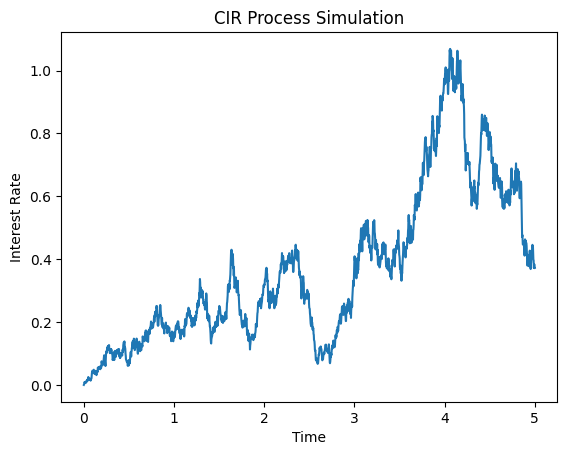

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_cir_process(a, b, sigma, r0, T, N):
    """
    Simulates the Cox-Ingersoll-Ross (CIR) process.

    Parameters:
    a (float): Speed of adjustment.
    b (float): Long-term mean level.
    sigma (float): Volatility parameter.
    r0 (float): Initial interest rate.
    T (float): Total time.
    N (int): Number of time steps.

    Returns:
    numpy.ndarray: Simulated interest rate path.
    """
    dt = T/N  # Time step
    rates = np.zeros(N+1)
    rates[0] = r0

    # Generate the random Wiener process increments
    dW = np.random.normal(scale=np.sqrt(dt), size=N)

    for i in range(1, N + 1):
        # Ensure the rate is positive to avoid taking a square root of a negative number
        rates[i] = rates[i-1] + a * (b - max(rates[i-1], 0)) * dt + sigma * np.sqrt(max(rates[i-1], 0)) * dW[i-1]

    return rates

# Set the parameters
a = 0.5    # Speed of adjustment
b = 1  # Long-term mean level
sigma = a # Volatility
r0 = 0   # Initial interest rate
T = 5      # Total time in years
N = 2000     # Number of time steps

# Simulate the CIR process
interest_rate_path = simulate_cir_process(a, b, sigma, r0, T, N)

# Plot the simulated CIR process
plt.plot(np.linspace(0, T, N+1), interest_rate_path)
plt.title('CIR Process Simulation')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.show()
